In [15]:
import datetime
import numpy as np
import pandas_datareader as pdr
import esig
from tqdm.auto import tqdm
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import base
from utils import tosig
from utils.leadlag import leadlag
from rough_bergomi import rough_bergomi

from importlib import reload
import cvae_keras
reload(cvae_keras)
import cvae_tfp
reload(cvae_tfp)

import matplotlib.pyplot as plt

## Data processing

In [16]:
# # S&P 500
# data = pdr.get_data_yahoo("^GSPC", datetime.date(2000, 1, 1), datetime.date(2019, 1, 1))["Close"]
# windows = []
# for _, window in data.resample('M'):
#     values = window.values
#     path = leadlag(values)
#     windows.append(path)

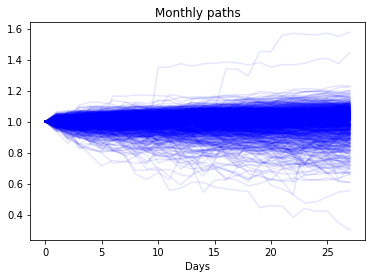

In [17]:
# Actually for rough_bergomi model, conditional VAE does no help because the cond are independent

# rough_bergomi
params = {
            "M": 1000,
            "H": 0.14,
            "rho": -0.85,
            "xi0": 0.1,
            "nu": 1.5,
            "S0": 1.
          }

def _load_rough_bergomi(params, test_use = False):
    grid_points_dict = {"M": 28, "W": 5, "Y": 252}
    grid_points = grid_points_dict['M']
    params["T"] = grid_points / grid_points_dict["Y"]
    paths = rough_bergomi(grid_points, **params)
    if test_use:
        windows = paths
    else:   
        windows = [leadlag(path) for path in paths]
    return windows

windows = _load_rough_bergomi(params)

for path in windows:
    returns = path[::2, 1] / path[0, 1]
    plt.plot(returns, "b", alpha=0.1)

plt.title("Monthly paths")
plt.xlabel("Days")
plt.show()

## Log-signature computing

In [18]:
order = 4
def _logsig(path):
    return esig.tosig.stream2logsig(path, order)
def _sig(path):
    return esig.tosig.stream2sig(path, order)

train_windows = _load_rough_bergomi(params)
train_logsig = np.array([_logsig(path) for path in tqdm(train_windows, desc="Computing log-signatures")])
train_sig = np.array([_sig(path) for path in tqdm(train_windows, desc="Computing signatures")])

test_windows = _load_rough_bergomi(params)
test_logsig = np.array([_logsig(path) for path in tqdm(test_windows, desc="Computing log-signatures")])
test_sig = np.array([_sig(path) for path in tqdm(test_windows, desc="Computing signatures")])

scaler = MinMaxScaler(feature_range=(0.00001, 0.99999))
logsig_transformed = scaler.fit_transform(train_logsig)
data = logsig_transformed[1:]   # 1 week forecasting 1 week 
data_cond = logsig_transformed[:-1] 

## CVAE

In [19]:
# Standard normal (tfp)
reload(cvae_tfp)
sample_dim = data.shape[0]
data_dim = data.shape[-1]
cond_dim = data_cond.shape[-1]
latent_dim = 8
hidden_dim = 50
weight = 0.003

x_input = [data, data_cond]
encoder = cvae_tfp.Encoder(data_dim, cond_dim, latent_dim, hidden_dim)
sampler = cvae_tfp.NormalSampler(latent_dim)
encodersampler = cvae_tfp.EncoderSampler(encoder,sampler)
decoder = cvae_tfp.Decoder(data_dim, cond_dim, latent_dim, hidden_dim)
model_normal = cvae_tfp.CVAE_bergomi(data_dim, cond_dim, latent_dim, hidden_dim, weight, decoder, encodersampler)
model_normal.compile(optimizer='adam', loss=cvae_tfp.zero_error)
model_normal.fit(x = x_input, y = data, epochs=5000,batch_size=sample_dim, verbose = True)

normalised_generated1 = model_normal.generate(data_cond)
generated_logsig1 = scaler.inverse_transform(normalised_generated1)
generated_sig1 = np.array([tosig.logsig2sig(logsig, 2, order) for logsig in tqdm(generated_logsig1)])

Epoch 1/5000
1/1 [==============================] - 1s 1s/step - loss: 0.8359
Epoch 2/5000
1/1 [==============================] - 0s 13ms/step - loss: 0.7837
Epoch 3/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.7410
Epoch 4/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.6967
Epoch 5/5000
1/1 [==============================] - 0s 2ms/step - loss: 0.6617
Epoch 6/5000
1/1 [==============================] - 0s 5ms/step - loss: 0.6145
Epoch 7/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.5821
Epoch 8/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.5402
Epoch 9/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.5105
Epoch 10/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.4707
Epoch 11/5000
1/1 [==============================] - 0s 5ms/step - loss: 0.4351
Epoch 12/5000
1/1 [==============================] - 0s 4ms/step - loss: 0.4020
Epoch 13/5000
1/1 [==============================

1/1 [==============================] - 0s 3ms/step - loss: 0.0562
Epoch 104/5000
1/1 [==============================] - 0s 4ms/step - loss: 0.0567
Epoch 105/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0551
Epoch 106/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0544
Epoch 107/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0561
Epoch 108/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0556
Epoch 109/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0557
Epoch 110/5000
1/1 [==============================] - 0s 4ms/step - loss: 0.0561
Epoch 111/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0560
Epoch 112/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0548
Epoch 113/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0544
Epoch 114/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0550
Epoch 115/5000
1/1 [=======================

1/1 [==============================] - 0s 3ms/step - loss: 0.0463
Epoch 205/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0458
Epoch 206/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0457
Epoch 207/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0449
Epoch 208/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0451
Epoch 209/5000
1/1 [==============================] - 0s 4ms/step - loss: 0.0469
Epoch 210/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0462
Epoch 211/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0447
Epoch 212/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0441
Epoch 213/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0456
Epoch 214/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0453
Epoch 215/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0453
Epoch 216/5000
1/1 [=======================

1/1 [==============================] - 0s 3ms/step - loss: 0.0404
Epoch 306/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0407
Epoch 307/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0407
Epoch 308/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0406
Epoch 309/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0402
Epoch 310/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0404
Epoch 311/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0403
Epoch 312/5000
1/1 [==============================] - 0s 2ms/step - loss: 0.0406
Epoch 313/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0406
Epoch 314/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0403
Epoch 315/5000
1/1 [==============================] - 0s 4ms/step - loss: 0.0399
Epoch 316/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0396
Epoch 317/5000
1/1 [=======================

1/1 [==============================] - 0s 4ms/step - loss: 0.0380
Epoch 407/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0378
Epoch 408/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0377
Epoch 409/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0382
Epoch 410/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0377
Epoch 411/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0378
Epoch 412/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0378
Epoch 413/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0380
Epoch 414/5000
1/1 [==============================] - 0s 2ms/step - loss: 0.0382
Epoch 415/5000
1/1 [==============================] - 0s 4ms/step - loss: 0.0383
Epoch 416/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0376
Epoch 417/5000
1/1 [==============================] - 0s 4ms/step - loss: 0.0378
Epoch 418/5000
1/1 [=======================

1/1 [==============================] - 0s 3ms/step - loss: 0.0366
Epoch 508/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0366
Epoch 509/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0366
Epoch 510/5000
1/1 [==============================] - 0s 4ms/step - loss: 0.0363
Epoch 511/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0362
Epoch 512/5000
1/1 [==============================] - 0s 2ms/step - loss: 0.0367
Epoch 513/5000
1/1 [==============================] - 0s 2ms/step - loss: 0.0371
Epoch 514/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0371
Epoch 515/5000
1/1 [==============================] - 0s 4ms/step - loss: 0.0362
Epoch 516/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0370
Epoch 517/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0363
Epoch 518/5000
1/1 [==============================] - 0s 2ms/step - loss: 0.0364
Epoch 519/5000
1/1 [=======================

1/1 [==============================] - 0s 3ms/step - loss: 0.0354
Epoch 609/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0356
Epoch 610/5000
1/1 [==============================] - 0s 9ms/step - loss: 0.0358
Epoch 611/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0360
Epoch 612/5000
1/1 [==============================] - 0s 4ms/step - loss: 0.0359
Epoch 613/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0358
Epoch 614/5000
1/1 [==============================] - 0s 4ms/step - loss: 0.0356
Epoch 615/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0349
Epoch 616/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0362
Epoch 617/5000
1/1 [==============================] - 0s 4ms/step - loss: 0.0356
Epoch 618/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0349
Epoch 619/5000
1/1 [==============================] - 0s 5ms/step - loss: 0.0351
Epoch 620/5000
1/1 [=======================

1/1 [==============================] - 0s 3ms/step - loss: 0.0336
Epoch 710/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0339
Epoch 711/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0340
Epoch 712/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0343
Epoch 713/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0350
Epoch 714/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0337
Epoch 715/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0338
Epoch 716/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0334
Epoch 717/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0340
Epoch 718/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0339
Epoch 719/5000
1/1 [==============================] - 0s 2ms/step - loss: 0.0334
Epoch 720/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0337
Epoch 721/5000
1/1 [=======================

1/1 [==============================] - 0s 3ms/step - loss: 0.0284
Epoch 811/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0289
Epoch 812/5000
1/1 [==============================] - 0s 4ms/step - loss: 0.0288
Epoch 813/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0285
Epoch 814/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0289
Epoch 815/5000
1/1 [==============================] - 0s 4ms/step - loss: 0.0282
Epoch 816/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0268
Epoch 817/5000
1/1 [==============================] - 0s 4ms/step - loss: 0.0278
Epoch 818/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0275
Epoch 819/5000
1/1 [==============================] - 0s 4ms/step - loss: 0.0278
Epoch 820/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0276
Epoch 821/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0285
Epoch 822/5000
1/1 [=======================

1/1 [==============================] - 0s 2ms/step - loss: 0.0227
Epoch 912/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0234
Epoch 913/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0234
Epoch 914/5000
1/1 [==============================] - 0s 4ms/step - loss: 0.0236
Epoch 915/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0234
Epoch 916/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0230
Epoch 917/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0230
Epoch 918/5000
1/1 [==============================] - 0s 4ms/step - loss: 0.0225
Epoch 919/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0228
Epoch 920/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0232
Epoch 921/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0230
Epoch 922/5000
1/1 [==============================] - 0s 2ms/step - loss: 0.0225
Epoch 923/5000
1/1 [=======================

1/1 [==============================] - 0s 3ms/step - loss: 0.0214
Epoch 1013/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0219
Epoch 1014/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0219
Epoch 1015/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0222
Epoch 1016/5000
1/1 [==============================] - 0s 4ms/step - loss: 0.0213
Epoch 1017/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0221
Epoch 1018/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0219
Epoch 1019/5000
1/1 [==============================] - 0s 4ms/step - loss: 0.0219
Epoch 1020/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0216
Epoch 1021/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0215
Epoch 1022/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0207
Epoch 1023/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0216
Epoch 1024/5000
1/1 [===========

1/1 [==============================] - 0s 3ms/step - loss: 0.0206
Epoch 1113/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0202
Epoch 1114/5000
1/1 [==============================] - 0s 2ms/step - loss: 0.0211
Epoch 1115/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0207
Epoch 1116/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0205
Epoch 1117/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0204
Epoch 1118/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0204
Epoch 1119/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0204
Epoch 1120/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0200
Epoch 1121/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0203
Epoch 1122/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0207
Epoch 1123/5000
1/1 [==============================] - 0s 4ms/step - loss: 0.0209
Epoch 1124/5000
1/1 [===========

1/1 [==============================] - 0s 3ms/step - loss: 0.0193
Epoch 1213/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0195
Epoch 1214/5000
1/1 [==============================] - 0s 2ms/step - loss: 0.0195
Epoch 1215/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0199
Epoch 1216/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0198
Epoch 1217/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0202
Epoch 1218/5000
1/1 [==============================] - 0s 2ms/step - loss: 0.0196
Epoch 1219/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0200
Epoch 1220/5000
1/1 [==============================] - 0s 2ms/step - loss: 0.0201
Epoch 1221/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0202
Epoch 1222/5000
1/1 [==============================] - 0s 4ms/step - loss: 0.0199
Epoch 1223/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0197
Epoch 1224/5000
1/1 [===========

1/1 [==============================] - 0s 4ms/step - loss: 0.0193
Epoch 1313/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0194
Epoch 1314/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0192
Epoch 1315/5000
1/1 [==============================] - 0s 6ms/step - loss: 0.0194
Epoch 1316/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0192
Epoch 1317/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0193
Epoch 1318/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0195
Epoch 1319/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0192
Epoch 1320/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0192
Epoch 1321/5000
1/1 [==============================] - 0s 4ms/step - loss: 0.0188
Epoch 1322/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0191
Epoch 1323/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0193
Epoch 1324/5000
1/1 [===========

1/1 [==============================] - 0s 4ms/step - loss: 0.0182
Epoch 1413/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0191
Epoch 1414/5000
1/1 [==============================] - 0s 4ms/step - loss: 0.0190
Epoch 1415/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0188
Epoch 1416/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0185
Epoch 1417/5000
1/1 [==============================] - 0s 2ms/step - loss: 0.0182
Epoch 1418/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0181
Epoch 1419/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0186
Epoch 1420/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0188
Epoch 1421/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0189
Epoch 1422/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0188
Epoch 1423/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0188
Epoch 1424/5000
1/1 [===========

1/1 [==============================] - 0s 3ms/step - loss: 0.0186
Epoch 1513/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0181
Epoch 1514/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0179
Epoch 1515/5000
1/1 [==============================] - 0s 4ms/step - loss: 0.0184
Epoch 1516/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0184
Epoch 1517/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0184
Epoch 1518/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0182
Epoch 1519/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0177
Epoch 1520/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0182
Epoch 1521/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0187
Epoch 1522/5000
1/1 [==============================] - 0s 2ms/step - loss: 0.0184
Epoch 1523/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0179
Epoch 1524/5000
1/1 [===========

1/1 [==============================] - 0s 3ms/step - loss: 0.0177
Epoch 1613/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0181
Epoch 1614/5000
1/1 [==============================] - 0s 2ms/step - loss: 0.0180
Epoch 1615/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0187
Epoch 1616/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0178
Epoch 1617/5000
1/1 [==============================] - 0s 2ms/step - loss: 0.0174
Epoch 1618/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0182
Epoch 1619/5000
1/1 [==============================] - 0s 4ms/step - loss: 0.0183
Epoch 1620/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0175
Epoch 1621/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0177
Epoch 1622/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0179
Epoch 1623/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0178
Epoch 1624/5000
1/1 [===========

1/1 [==============================] - 0s 3ms/step - loss: 0.0176
Epoch 1713/5000
1/1 [==============================] - 0s 2ms/step - loss: 0.0172
Epoch 1714/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0171
Epoch 1715/5000
1/1 [==============================] - 0s 4ms/step - loss: 0.0172
Epoch 1716/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0178
Epoch 1717/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0176
Epoch 1718/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0177
Epoch 1719/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0176
Epoch 1720/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0177
Epoch 1721/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0175
Epoch 1722/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0177
Epoch 1723/5000
1/1 [==============================] - 0s 2ms/step - loss: 0.0174
Epoch 1724/5000
1/1 [===========

1/1 [==============================] - 0s 3ms/step - loss: 0.0176
Epoch 1813/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0175
Epoch 1814/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0169
Epoch 1815/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0172
Epoch 1816/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0169
Epoch 1817/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0174
Epoch 1818/5000
1/1 [==============================] - 0s 4ms/step - loss: 0.0166
Epoch 1819/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0172
Epoch 1820/5000
1/1 [==============================] - 0s 2ms/step - loss: 0.0167
Epoch 1821/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0172
Epoch 1822/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0175
Epoch 1823/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0171
Epoch 1824/5000
1/1 [===========

1/1 [==============================] - 0s 3ms/step - loss: 0.0170
Epoch 1913/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0174
Epoch 1914/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0174
Epoch 1915/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0171
Epoch 1916/5000
1/1 [==============================] - 0s 2ms/step - loss: 0.0171
Epoch 1917/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0170
Epoch 1918/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0170
Epoch 1919/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0169
Epoch 1920/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0172
Epoch 1921/5000
1/1 [==============================] - 0s 2ms/step - loss: 0.0165
Epoch 1922/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0168
Epoch 1923/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0168
Epoch 1924/5000
1/1 [===========

1/1 [==============================] - 0s 3ms/step - loss: 0.0163
Epoch 2013/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0168
Epoch 2014/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0167
Epoch 2015/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0167
Epoch 2016/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0161
Epoch 2017/5000
1/1 [==============================] - 0s 4ms/step - loss: 0.0168
Epoch 2018/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0164
Epoch 2019/5000
1/1 [==============================] - 0s 2ms/step - loss: 0.0165
Epoch 2020/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0164
Epoch 2021/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0164
Epoch 2022/5000
1/1 [==============================] - 0s 4ms/step - loss: 0.0167
Epoch 2023/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0166
Epoch 2024/5000
1/1 [===========

1/1 [==============================] - 0s 3ms/step - loss: 0.0164
Epoch 2113/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0165
Epoch 2114/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0159
Epoch 2115/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0164
Epoch 2116/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0164
Epoch 2117/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0167
Epoch 2118/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0160
Epoch 2119/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0163
Epoch 2120/5000
1/1 [==============================] - 0s 4ms/step - loss: 0.0162
Epoch 2121/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0164
Epoch 2122/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0161
Epoch 2123/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0165
Epoch 2124/5000
1/1 [===========

1/1 [==============================] - 0s 3ms/step - loss: 0.0163
Epoch 2213/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0158
Epoch 2214/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0161
Epoch 2215/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0163
Epoch 2216/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0159
Epoch 2217/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0161
Epoch 2218/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0163
Epoch 2219/5000
1/1 [==============================] - 0s 4ms/step - loss: 0.0158
Epoch 2220/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0156
Epoch 2221/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0160
Epoch 2222/5000
1/1 [==============================] - 0s 4ms/step - loss: 0.0162
Epoch 2223/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0158
Epoch 2224/5000
1/1 [===========

1/1 [==============================] - 0s 3ms/step - loss: 0.0152
Epoch 2313/5000
1/1 [==============================] - 0s 4ms/step - loss: 0.0152
Epoch 2314/5000
1/1 [==============================] - 0s 4ms/step - loss: 0.0157
Epoch 2315/5000
1/1 [==============================] - 0s 5ms/step - loss: 0.0150
Epoch 2316/5000
1/1 [==============================] - 0s 4ms/step - loss: 0.0156
Epoch 2317/5000
1/1 [==============================] - 0s 4ms/step - loss: 0.0156
Epoch 2318/5000
1/1 [==============================] - 0s 5ms/step - loss: 0.0160
Epoch 2319/5000
1/1 [==============================] - 0s 4ms/step - loss: 0.0154
Epoch 2320/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0155
Epoch 2321/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0157
Epoch 2322/5000
1/1 [==============================] - 0s 5ms/step - loss: 0.0155
Epoch 2323/5000
1/1 [==============================] - 0s 4ms/step - loss: 0.0153
Epoch 2324/5000
1/1 [===========

1/1 [==============================] - 0s 3ms/step - loss: 0.0154
Epoch 2413/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0151
Epoch 2414/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0152
Epoch 2415/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0151
Epoch 2416/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0150
Epoch 2417/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0150
Epoch 2418/5000
1/1 [==============================] - 0s 2ms/step - loss: 0.0152
Epoch 2419/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0153
Epoch 2420/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0151
Epoch 2421/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0153
Epoch 2422/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0153
Epoch 2423/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0155
Epoch 2424/5000
1/1 [===========

1/1 [==============================] - 0s 3ms/step - loss: 0.0145
Epoch 2513/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0144
Epoch 2514/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0147
Epoch 2515/5000
1/1 [==============================] - 0s 4ms/step - loss: 0.0147
Epoch 2516/5000
1/1 [==============================] - 0s 2ms/step - loss: 0.0143
Epoch 2517/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0145
Epoch 2518/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0150
Epoch 2519/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0147
Epoch 2520/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0146
Epoch 2521/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0141
Epoch 2522/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0143
Epoch 2523/5000
1/1 [==============================] - 0s 4ms/step - loss: 0.0148
Epoch 2524/5000
1/1 [===========

1/1 [==============================] - 0s 3ms/step - loss: 0.0140
Epoch 2613/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0146
Epoch 2614/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0138
Epoch 2615/5000
1/1 [==============================] - 0s 4ms/step - loss: 0.0145
Epoch 2616/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0142
Epoch 2617/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0145
Epoch 2618/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0143
Epoch 2619/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0144
Epoch 2620/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0141
Epoch 2621/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0143
Epoch 2622/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0145
Epoch 2623/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0141
Epoch 2624/5000
1/1 [===========

1/1 [==============================] - 0s 2ms/step - loss: 0.0138
Epoch 2713/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0138
Epoch 2714/5000
1/1 [==============================] - 0s 2ms/step - loss: 0.0139
Epoch 2715/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0139
Epoch 2716/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0138
Epoch 2717/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0138
Epoch 2718/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0140
Epoch 2719/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0141
Epoch 2720/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0138
Epoch 2721/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0139
Epoch 2722/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0137
Epoch 2723/5000
1/1 [==============================] - 0s 2ms/step - loss: 0.0136
Epoch 2724/5000
1/1 [===========

1/1 [==============================] - 0s 3ms/step - loss: 0.0139
Epoch 2813/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0136
Epoch 2814/5000
1/1 [==============================] - 0s 2ms/step - loss: 0.0136
Epoch 2815/5000
1/1 [==============================] - 0s 4ms/step - loss: 0.0137
Epoch 2816/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0137
Epoch 2817/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0139
Epoch 2818/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0136
Epoch 2819/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0137
Epoch 2820/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0133
Epoch 2821/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0139
Epoch 2822/5000
1/1 [==============================] - 0s 4ms/step - loss: 0.0137
Epoch 2823/5000
1/1 [==============================] - 0s 4ms/step - loss: 0.0134
Epoch 2824/5000
1/1 [===========

1/1 [==============================] - 0s 2ms/step - loss: 0.0141
Epoch 2913/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0134
Epoch 2914/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0136
Epoch 2915/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0135
Epoch 2916/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0139
Epoch 2917/5000
1/1 [==============================] - 0s 4ms/step - loss: 0.0136
Epoch 2918/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0137
Epoch 2919/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0136
Epoch 2920/5000
1/1 [==============================] - 0s 2ms/step - loss: 0.0135
Epoch 2921/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0135
Epoch 2922/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0136
Epoch 2923/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0135
Epoch 2924/5000
1/1 [===========

1/1 [==============================] - 0s 4ms/step - loss: 0.0135
Epoch 3013/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0136
Epoch 3014/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0136
Epoch 3015/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0132
Epoch 3016/5000
1/1 [==============================] - 0s 4ms/step - loss: 0.0134
Epoch 3017/5000
1/1 [==============================] - 0s 2ms/step - loss: 0.0133
Epoch 3018/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0132
Epoch 3019/5000
1/1 [==============================] - 0s 2ms/step - loss: 0.0134
Epoch 3020/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0133
Epoch 3021/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0131
Epoch 3022/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0133
Epoch 3023/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0138
Epoch 3024/5000
1/1 [===========

1/1 [==============================] - 0s 4ms/step - loss: 0.0130
Epoch 3113/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0131
Epoch 3114/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0135
Epoch 3115/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0131
Epoch 3116/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0134
Epoch 3117/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0131
Epoch 3118/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0134
Epoch 3119/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0133
Epoch 3120/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0132
Epoch 3121/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0130
Epoch 3122/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0131
Epoch 3123/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0132
Epoch 3124/5000
1/1 [===========

Epoch 3212/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0131
Epoch 3213/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0134
Epoch 3214/5000
1/1 [==============================] - 0s 2ms/step - loss: 0.0132
Epoch 3215/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0130
Epoch 3216/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0128
Epoch 3217/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0130
Epoch 3218/5000
1/1 [==============================] - 0s 2ms/step - loss: 0.0131
Epoch 3219/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0129
Epoch 3220/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0133
Epoch 3221/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0133
Epoch 3222/5000
1/1 [==============================] - 0s 4ms/step - loss: 0.0129
Epoch 3223/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0134
Epoch 3224/5000


1/1 [==============================] - 0s 4ms/step - loss: 0.0130
Epoch 3312/5000
1/1 [==============================] - 0s 4ms/step - loss: 0.0131
Epoch 3313/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0127
Epoch 3314/5000
1/1 [==============================] - 0s 4ms/step - loss: 0.0128
Epoch 3315/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0133
Epoch 3316/5000
1/1 [==============================] - 0s 4ms/step - loss: 0.0130
Epoch 3317/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0127
Epoch 3318/5000
1/1 [==============================] - 0s 4ms/step - loss: 0.0129
Epoch 3319/5000
1/1 [==============================] - 0s 5ms/step - loss: 0.0128
Epoch 3320/5000
1/1 [==============================] - 0s 4ms/step - loss: 0.0129
Epoch 3321/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0130
Epoch 3322/5000
1/1 [==============================] - 0s 6ms/step - loss: 0.0129
Epoch 3323/5000
1/1 [===========

1/1 [==============================] - 0s 3ms/step - loss: 0.0128
Epoch 3412/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0130
Epoch 3413/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0127
Epoch 3414/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0129
Epoch 3415/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0127
Epoch 3416/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0129
Epoch 3417/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0124
Epoch 3418/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0127
Epoch 3419/5000
1/1 [==============================] - 0s 4ms/step - loss: 0.0128
Epoch 3420/5000
1/1 [==============================] - 0s 4ms/step - loss: 0.0130
Epoch 3421/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0127
Epoch 3422/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0130
Epoch 3423/5000
1/1 [===========

1/1 [==============================] - 0s 4ms/step - loss: 0.0126
Epoch 3512/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0128
Epoch 3513/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0125
Epoch 3514/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0132
Epoch 3515/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0128
Epoch 3516/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0128
Epoch 3517/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0127
Epoch 3518/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0128
Epoch 3519/5000
1/1 [==============================] - 0s 2ms/step - loss: 0.0126
Epoch 3520/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0128
Epoch 3521/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0127
Epoch 3522/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0130
Epoch 3523/5000
1/1 [===========

1/1 [==============================] - 0s 4ms/step - loss: 0.0127
Epoch 3612/5000
1/1 [==============================] - 0s 10ms/step - loss: 0.0125
Epoch 3613/5000
1/1 [==============================] - 0s 2ms/step - loss: 0.0126
Epoch 3614/5000
1/1 [==============================] - 0s 2ms/step - loss: 0.0126
Epoch 3615/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0124
Epoch 3616/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0124
Epoch 3617/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0129
Epoch 3618/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0124
Epoch 3619/5000
1/1 [==============================] - 0s 4ms/step - loss: 0.0128
Epoch 3620/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0128
Epoch 3621/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0127
Epoch 3622/5000
1/1 [==============================] - 0s 4ms/step - loss: 0.0129
Epoch 3623/5000
1/1 [==========

1/1 [==============================] - 0s 4ms/step - loss: 0.0127
Epoch 3712/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0127
Epoch 3713/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0126
Epoch 3714/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0125
Epoch 3715/5000
1/1 [==============================] - 0s 4ms/step - loss: 0.0126
Epoch 3716/5000
1/1 [==============================] - 0s 2ms/step - loss: 0.0126
Epoch 3717/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0128
Epoch 3718/5000
1/1 [==============================] - 0s 4ms/step - loss: 0.0126
Epoch 3719/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0126
Epoch 3720/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0123
Epoch 3721/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0128
Epoch 3722/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0123
Epoch 3723/5000
1/1 [===========

1/1 [==============================] - 0s 0s/step - loss: 0.0126
Epoch 3812/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0123
Epoch 3813/5000
1/1 [==============================] - 0s 16ms/step - loss: 0.0127
Epoch 3814/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0124
Epoch 3815/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0125
Epoch 3816/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0125
Epoch 3817/5000
1/1 [==============================] - 0s 16ms/step - loss: 0.0126
Epoch 3818/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0125
Epoch 3819/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0123
Epoch 3820/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0123
Epoch 3821/5000
1/1 [==============================] - 0s 16ms/step - loss: 0.0123
Epoch 3822/5000
1/1 [==============================] - 0s 0s/step - loss: 0.0125
Epoch 3823/5000
1/1 [=================

1/1 [==============================] - 0s 3ms/step - loss: 0.0123
Epoch 3912/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0124
Epoch 3913/5000
1/1 [==============================] - 0s 2ms/step - loss: 0.0125
Epoch 3914/5000
1/1 [==============================] - 0s 2ms/step - loss: 0.0124
Epoch 3915/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0122
Epoch 3916/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0123
Epoch 3917/5000
1/1 [==============================] - 0s 4ms/step - loss: 0.0121
Epoch 3918/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0123
Epoch 3919/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0122
Epoch 3920/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0123
Epoch 3921/5000
1/1 [==============================] - 0s 4ms/step - loss: 0.0121
Epoch 3922/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0124
Epoch 3923/5000
1/1 [===========

1/1 [==============================] - 0s 3ms/step - loss: 0.0121
Epoch 4012/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0123
Epoch 4013/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0123
Epoch 4014/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0122
Epoch 4015/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0120
Epoch 4016/5000
1/1 [==============================] - 0s 2ms/step - loss: 0.0121
Epoch 4017/5000
1/1 [==============================] - 0s 2ms/step - loss: 0.0121
Epoch 4018/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0120
Epoch 4019/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0124
Epoch 4020/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0121
Epoch 4021/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0122
Epoch 4022/5000
1/1 [==============================] - 0s 2ms/step - loss: 0.0121
Epoch 4023/5000
1/1 [===========

1/1 [==============================] - 0s 3ms/step - loss: 0.0121
Epoch 4112/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0119
Epoch 4113/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0121
Epoch 4114/5000
1/1 [==============================] - 0s 4ms/step - loss: 0.0120
Epoch 4115/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0122
Epoch 4116/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0118
Epoch 4117/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0123
Epoch 4118/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0121
Epoch 4119/5000
1/1 [==============================] - 0s 4ms/step - loss: 0.0125
Epoch 4120/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0119
Epoch 4121/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0121
Epoch 4122/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0121
Epoch 4123/5000
1/1 [===========

1/1 [==============================] - 0s 3ms/step - loss: 0.0121
Epoch 4212/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0120
Epoch 4213/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0120
Epoch 4214/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0122
Epoch 4215/5000
1/1 [==============================] - 0s 4ms/step - loss: 0.0120
Epoch 4216/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0120
Epoch 4217/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0120
Epoch 4218/5000
1/1 [==============================] - 0s 4ms/step - loss: 0.0121
Epoch 4219/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0120
Epoch 4220/5000
1/1 [==============================] - 0s 4ms/step - loss: 0.0121
Epoch 4221/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0120
Epoch 4222/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0120
Epoch 4223/5000
1/1 [===========

1/1 [==============================] - 0s 3ms/step - loss: 0.0120
Epoch 4312/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0122
Epoch 4313/5000
1/1 [==============================] - 0s 2ms/step - loss: 0.0121
Epoch 4314/5000
1/1 [==============================] - 0s 2ms/step - loss: 0.0120
Epoch 4315/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0117
Epoch 4316/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0119
Epoch 4317/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0118
Epoch 4318/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0121
Epoch 4319/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0120
Epoch 4320/5000
1/1 [==============================] - 0s 4ms/step - loss: 0.0119
Epoch 4321/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0116
Epoch 4322/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0119
Epoch 4323/5000
1/1 [===========

1/1 [==============================] - 0s 3ms/step - loss: 0.0118
Epoch 4412/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0118
Epoch 4413/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0118
Epoch 4414/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0118
Epoch 4415/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0119
Epoch 4416/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0117
Epoch 4417/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0120
Epoch 4418/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0117
Epoch 4419/5000
1/1 [==============================] - 0s 4ms/step - loss: 0.0119
Epoch 4420/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0120
Epoch 4421/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0116
Epoch 4422/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0120
Epoch 4423/5000
1/1 [===========

1/1 [==============================] - 0s 2ms/step - loss: 0.0116
Epoch 4512/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0118
Epoch 4513/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0118
Epoch 4514/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0120
Epoch 4515/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0118
Epoch 4516/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0119
Epoch 4517/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0116
Epoch 4518/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0117
Epoch 4519/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0117
Epoch 4520/5000
1/1 [==============================] - 0s 2ms/step - loss: 0.0118
Epoch 4521/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0116
Epoch 4522/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0118
Epoch 4523/5000
1/1 [===========

1/1 [==============================] - 0s 3ms/step - loss: 0.0116
Epoch 4612/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0114
Epoch 4613/5000
1/1 [==============================] - 0s 4ms/step - loss: 0.0117
Epoch 4614/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0116
Epoch 4615/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0116
Epoch 4616/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0114
Epoch 4617/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0116
Epoch 4618/5000
1/1 [==============================] - 0s 4ms/step - loss: 0.0116
Epoch 4619/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0115
Epoch 4620/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0116
Epoch 4621/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0114
Epoch 4622/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0113
Epoch 4623/5000
1/1 [===========

1/1 [==============================] - 0s 3ms/step - loss: 0.0117
Epoch 4712/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0123
Epoch 4713/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0117
Epoch 4714/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0117
Epoch 4715/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0114
Epoch 4716/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0113
Epoch 4717/5000
1/1 [==============================] - 0s 4ms/step - loss: 0.0117
Epoch 4718/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0115
Epoch 4719/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0118
Epoch 4720/5000
1/1 [==============================] - 0s 2ms/step - loss: 0.0113
Epoch 4721/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0115
Epoch 4722/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0116
Epoch 4723/5000
1/1 [===========

1/1 [==============================] - 0s 3ms/step - loss: 0.0113
Epoch 4812/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0114
Epoch 4813/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0115
Epoch 4814/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0114
Epoch 4815/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0113
Epoch 4816/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0116
Epoch 4817/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0115
Epoch 4818/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0114
Epoch 4819/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0113
Epoch 4820/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0113
Epoch 4821/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0114
Epoch 4822/5000
1/1 [==============================] - 0s 2ms/step - loss: 0.0119
Epoch 4823/5000
1/1 [===========

1/1 [==============================] - 0s 3ms/step - loss: 0.0115
Epoch 4912/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0115
Epoch 4913/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0114
Epoch 4914/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0111
Epoch 4915/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0113
Epoch 4916/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0112
Epoch 4917/5000
1/1 [==============================] - 0s 4ms/step - loss: 0.0114
Epoch 4918/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0112
Epoch 4919/5000
1/1 [==============================] - 0s 4ms/step - loss: 0.0116
Epoch 4920/5000
1/1 [==============================] - 0s 4ms/step - loss: 0.0112
Epoch 4921/5000
1/1 [==============================] - 0s 3ms/step - loss: 0.0116
Epoch 4922/5000
1/1 [==============================] - 0s 4ms/step - loss: 0.0113
Epoch 4923/5000
1/1 [===========

In [32]:
# Student-t (tfp)
reload(cvae_tfp)
sample_dim = data.shape[0]
data_dim = data.shape[-1]
cond_dim = data_cond.shape[-1]
latent_dim = 8
hidden_dim = 50
weight = 0.003

x_input = [data, data_cond]
encoder = cvae_tfp.Encoder_Pseudo(data_dim, cond_dim, latent_dim, hidden_dim)
sampler = cvae_tfp.StudentSampler(latent_dim)
encodersampler = cvae_tfp.EncoderSampler(encoder,sampler)
decoder = cvae_tfp.Decoder(data_dim, cond_dim, latent_dim, hidden_dim)
model_student = cvae_tfp.CVAE_bergomi(data_dim, cond_dim, latent_dim, hidden_dim, weight, decoder, encodersampler)
model_student.compile(optimizer='adam', loss=cvae_tfp.zero_error)
model_student.fit(x = x_input, y = data, epochs=10000,batch_size=sample_dim, verbose = True)

normalised_generated2 = model_student.generate(data_cond)
generated_logsig2 = scaler.inverse_transform(normalised_generated2)
generated_sig2 = np.array([tosig.logsig2sig(logsig, 2, order) for logsig in tqdm(generated_logsig2)])

Epoch 1/10000
1/1 [==============================] - 2s 2s/step - loss: 1.4386
Epoch 2/10000
1/1 [==============================] - 0s 4ms/step - loss: 1.3887
Epoch 3/10000
1/1 [==============================] - 0s 4ms/step - loss: 1.3977
Epoch 4/10000
1/1 [==============================] - 0s 4ms/step - loss: 1.3256
Epoch 5/10000
1/1 [==============================] - 0s 4ms/step - loss: 1.2574
Epoch 6/10000
1/1 [==============================] - 0s 5ms/step - loss: 1.2370
Epoch 7/10000
1/1 [==============================] - 0s 5ms/step - loss: 1.1763
Epoch 8/10000
1/1 [==============================] - 0s 4ms/step - loss: 1.1670
Epoch 9/10000
1/1 [==============================] - 0s 4ms/step - loss: 1.1105
Epoch 10/10000
1/1 [==============================] - 0s 4ms/step - loss: 1.0509
Epoch 11/10000
1/1 [==============================] - 0s 4ms/step - loss: 1.0225
Epoch 12/10000
1/1 [==============================] - 0s 5ms/step - loss: 1.0071
Epoch 13/10000
1/1 [==================

1/1 [==============================] - 0s 5ms/step - loss: 0.0687
Epoch 103/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0670
Epoch 104/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0668
Epoch 105/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0674
Epoch 106/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0659
Epoch 107/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0689
Epoch 108/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0657
Epoch 109/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0666
Epoch 110/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0665
Epoch 111/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0667
Epoch 112/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0684
Epoch 113/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0656
Epoch 114/10000
1/1 [===========

1/1 [==============================] - 0s 5ms/step - loss: 0.0461
Epoch 203/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0474
Epoch 204/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0469
Epoch 205/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0478
Epoch 206/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0459
Epoch 207/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0473
Epoch 208/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0463
Epoch 209/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0471
Epoch 210/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0470
Epoch 211/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0475
Epoch 212/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0460
Epoch 213/10000
1/1 [==============================] - 0s 6ms/step - loss: 0.0465
Epoch 214/10000
1/1 [===========

1/1 [==============================] - 0s 4ms/step - loss: 0.0402
Epoch 303/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0392
Epoch 304/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0394
Epoch 305/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0399
Epoch 306/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0390
Epoch 307/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0400
Epoch 308/10000
1/1 [==============================] - 0s 6ms/step - loss: 0.0394
Epoch 309/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0393
Epoch 310/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0399
Epoch 311/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0391
Epoch 312/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0396
Epoch 313/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0394
Epoch 314/10000
1/1 [===========

1/1 [==============================] - 0s 5ms/step - loss: 0.0380
Epoch 403/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0378
Epoch 404/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0372
Epoch 405/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0380
Epoch 406/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0387
Epoch 407/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0380
Epoch 408/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0380
Epoch 409/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0379
Epoch 410/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0380
Epoch 411/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0375
Epoch 412/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0374
Epoch 413/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0377
Epoch 414/10000
1/1 [===========

1/1 [==============================] - 0s 6ms/step - loss: 0.0378
Epoch 503/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0366
Epoch 504/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0372
Epoch 505/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0373
Epoch 506/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0372
Epoch 507/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0365
Epoch 508/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0373
Epoch 509/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0369
Epoch 510/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0372
Epoch 511/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0369
Epoch 512/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0370
Epoch 513/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0375
Epoch 514/10000
1/1 [===========

1/1 [==============================] - 0s 4ms/step - loss: 0.0366
Epoch 603/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0365
Epoch 604/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0368
Epoch 605/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0360
Epoch 606/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0366
Epoch 607/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0361
Epoch 608/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0355
Epoch 609/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0363
Epoch 610/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0363
Epoch 611/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0367
Epoch 612/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0363
Epoch 613/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0366
Epoch 614/10000
1/1 [===========

1/1 [==============================] - 0s 4ms/step - loss: 0.0352
Epoch 703/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0357
Epoch 704/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0357
Epoch 705/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0360
Epoch 706/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0357
Epoch 707/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0360
Epoch 708/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0357
Epoch 709/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0360
Epoch 710/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0363
Epoch 711/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0361
Epoch 712/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0357
Epoch 713/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0358
Epoch 714/10000
1/1 [===========

1/1 [==============================] - 0s 4ms/step - loss: 0.0344
Epoch 803/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0338
Epoch 804/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0339
Epoch 805/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0340
Epoch 806/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0347
Epoch 807/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0333
Epoch 808/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0344
Epoch 809/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0339
Epoch 810/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0339
Epoch 811/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0339
Epoch 812/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0339
Epoch 813/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0341
Epoch 814/10000
1/1 [===========

1/1 [==============================] - 0s 4ms/step - loss: 0.0293
Epoch 903/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0290
Epoch 904/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0292
Epoch 905/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0292
Epoch 906/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0286
Epoch 907/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0278
Epoch 908/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0291
Epoch 909/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0292
Epoch 910/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0288
Epoch 911/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0281
Epoch 912/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0281
Epoch 913/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0280
Epoch 914/10000
1/1 [===========

1/1 [==============================] - 0s 4ms/step - loss: 0.0234
Epoch 1003/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0228
Epoch 1004/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0229
Epoch 1005/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0237
Epoch 1006/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0226
Epoch 1007/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0222
Epoch 1008/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0232
Epoch 1009/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0234
Epoch 1010/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0225
Epoch 1011/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0226
Epoch 1012/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0229
Epoch 1013/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0228
Epoch 1014/10000
1/1 

1/1 [==============================] - 0s 3ms/step - loss: 0.0205
Epoch 1101/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0206
Epoch 1102/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0204
Epoch 1103/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0208
Epoch 1104/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0206
Epoch 1105/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0206
Epoch 1106/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0204
Epoch 1107/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0204
Epoch 1108/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0200
Epoch 1109/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0202
Epoch 1110/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0212
Epoch 1111/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0207
Epoch 1112/10000
1/1 

1/1 [==============================] - 0s 4ms/step - loss: 0.0189
Epoch 1199/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0185
Epoch 1200/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0180
Epoch 1201/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0182
Epoch 1202/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0182
Epoch 1203/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0187
Epoch 1204/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0185
Epoch 1205/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0183
Epoch 1206/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0188
Epoch 1207/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0184
Epoch 1208/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0181
Epoch 1209/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0185
Epoch 1210/10000
1/1 

1/1 [==============================] - 0s 4ms/step - loss: 0.0167
Epoch 1297/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0163
Epoch 1298/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0165
Epoch 1299/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0161
Epoch 1300/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0163
Epoch 1301/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0161
Epoch 1302/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0163
Epoch 1303/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0164
Epoch 1304/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0160
Epoch 1305/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0164
Epoch 1306/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0165
Epoch 1307/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0161
Epoch 1308/10000
1/1 

1/1 [==============================] - 0s 4ms/step - loss: 0.0154
Epoch 1395/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0152
Epoch 1396/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0151
Epoch 1397/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0150
Epoch 1398/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0149
Epoch 1399/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0149
Epoch 1400/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0152
Epoch 1401/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0156
Epoch 1402/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0150
Epoch 1403/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0153
Epoch 1404/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0147
Epoch 1405/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0152
Epoch 1406/10000
1/1 

1/1 [==============================] - 0s 4ms/step - loss: 0.0143
Epoch 1493/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0138
Epoch 1494/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0143
Epoch 1495/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0146
Epoch 1496/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0144
Epoch 1497/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0142
Epoch 1498/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0145
Epoch 1499/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0145
Epoch 1500/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0145
Epoch 1501/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0141
Epoch 1502/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0141
Epoch 1503/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0143
Epoch 1504/10000
1/1 

1/1 [==============================] - 0s 4ms/step - loss: 0.0139
Epoch 1591/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0138
Epoch 1592/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0139
Epoch 1593/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0139
Epoch 1594/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0137
Epoch 1595/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0144
Epoch 1596/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0141
Epoch 1597/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0136
Epoch 1598/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0140
Epoch 1599/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0138
Epoch 1600/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0142
Epoch 1601/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0140
Epoch 1602/10000
1/1 

1/1 [==============================] - 0s 3ms/step - loss: 0.0135
Epoch 1689/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0134
Epoch 1690/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0136
Epoch 1691/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0134
Epoch 1692/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0136
Epoch 1693/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0134
Epoch 1694/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0136
Epoch 1695/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0136
Epoch 1696/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0133
Epoch 1697/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0136
Epoch 1698/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0139
Epoch 1699/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0138
Epoch 1700/10000
1/1 

1/1 [==============================] - 0s 3ms/step - loss: 0.0134
Epoch 1787/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0133
Epoch 1788/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0136
Epoch 1789/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0132
Epoch 1790/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0133
Epoch 1791/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0131
Epoch 1792/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0133
Epoch 1793/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0130
Epoch 1794/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0133
Epoch 1795/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0132
Epoch 1796/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0133
Epoch 1797/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0132
Epoch 1798/10000
1/1 

1/1 [==============================] - 0s 4ms/step - loss: 0.0130
Epoch 1885/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0133
Epoch 1886/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0131
Epoch 1887/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0135
Epoch 1888/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0132
Epoch 1889/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0132
Epoch 1890/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0129
Epoch 1891/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0133
Epoch 1892/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0132
Epoch 1893/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0132
Epoch 1894/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0132
Epoch 1895/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0131
Epoch 1896/10000
1/1 

1/1 [==============================] - 0s 4ms/step - loss: 0.0131
Epoch 1983/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0129
Epoch 1984/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0128
Epoch 1985/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0130
Epoch 1986/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0129
Epoch 1987/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0132
Epoch 1988/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0127
Epoch 1989/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0128
Epoch 1990/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0129
Epoch 1991/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0127
Epoch 1992/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0130
Epoch 1993/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0128
Epoch 1994/10000
1/1 

1/1 [==============================] - 0s 3ms/step - loss: 0.0126
Epoch 2081/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0126
Epoch 2082/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0127
Epoch 2083/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0127
Epoch 2084/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0129
Epoch 2085/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0127
Epoch 2086/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0126
Epoch 2087/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0127
Epoch 2088/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0127
Epoch 2089/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0126
Epoch 2090/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0127
Epoch 2091/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0127
Epoch 2092/10000
1/1 

1/1 [==============================] - 0s 3ms/step - loss: 0.0123
Epoch 2179/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0123
Epoch 2180/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0123
Epoch 2181/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0124
Epoch 2182/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0126
Epoch 2183/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0125
Epoch 2184/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0125
Epoch 2185/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0124
Epoch 2186/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0125
Epoch 2187/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0127
Epoch 2188/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0124
Epoch 2189/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0124
Epoch 2190/10000
1/1 

1/1 [==============================] - 0s 4ms/step - loss: 0.0123
Epoch 2277/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0124
Epoch 2278/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0126
Epoch 2279/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0125
Epoch 2280/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0126
Epoch 2281/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0127
Epoch 2282/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0122
Epoch 2283/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0121
Epoch 2284/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0126
Epoch 2285/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0121
Epoch 2286/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0123
Epoch 2287/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0122
Epoch 2288/10000
1/1 

1/1 [==============================] - 0s 4ms/step - loss: 0.0122
Epoch 2375/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0124
Epoch 2376/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0121
Epoch 2377/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0122
Epoch 2378/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0122
Epoch 2379/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0124
Epoch 2380/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0119
Epoch 2381/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0121
Epoch 2382/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0121
Epoch 2383/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0123
Epoch 2384/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0120
Epoch 2385/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0122
Epoch 2386/10000
1/1 

1/1 [==============================] - 0s 4ms/step - loss: 0.0119
Epoch 2473/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0117
Epoch 2474/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0119
Epoch 2475/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0121
Epoch 2476/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0120
Epoch 2477/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0119
Epoch 2478/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0121
Epoch 2479/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0120
Epoch 2480/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0122
Epoch 2481/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0122
Epoch 2482/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0121
Epoch 2483/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0120
Epoch 2484/10000
1/1 

1/1 [==============================] - 0s 4ms/step - loss: 0.0118
Epoch 2571/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0117
Epoch 2572/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0119
Epoch 2573/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0120
Epoch 2574/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0119
Epoch 2575/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0118
Epoch 2576/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0120
Epoch 2577/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0118
Epoch 2578/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0119
Epoch 2579/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0120
Epoch 2580/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0119
Epoch 2581/10000
1/1 [==============================] - 0s 6ms/step - loss: 0.0118
Epoch 2582/10000
1/1 

1/1 [==============================] - 0s 4ms/step - loss: 0.0118
Epoch 2669/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0117
Epoch 2670/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0119
Epoch 2671/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0117
Epoch 2672/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0117
Epoch 2673/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0118
Epoch 2674/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0118
Epoch 2675/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0117
Epoch 2676/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0115
Epoch 2677/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0118
Epoch 2678/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0119
Epoch 2679/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0119
Epoch 2680/10000
1/1 

1/1 [==============================] - 0s 4ms/step - loss: 0.0113
Epoch 2767/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0114
Epoch 2768/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0116
Epoch 2769/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0115
Epoch 2770/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0115
Epoch 2771/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0116
Epoch 2772/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0115
Epoch 2773/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0116
Epoch 2774/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0116
Epoch 2775/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0116
Epoch 2776/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0114
Epoch 2777/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0117
Epoch 2778/10000
1/1 

1/1 [==============================] - 0s 4ms/step - loss: 0.0117
Epoch 2865/10000
1/1 [==============================] - 0s 6ms/step - loss: 0.0114
Epoch 2866/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0114
Epoch 2867/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0114
Epoch 2868/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0116
Epoch 2869/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0114
Epoch 2870/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0114
Epoch 2871/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0121
Epoch 2872/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0115
Epoch 2873/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0114
Epoch 2874/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0116
Epoch 2875/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0112
Epoch 2876/10000
1/1 

1/1 [==============================] - 0s 5ms/step - loss: 0.0114
Epoch 2963/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0111
Epoch 2964/10000
1/1 [==============================] - 0s 6ms/step - loss: 0.0115
Epoch 2965/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0112
Epoch 2966/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0113
Epoch 2967/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0114
Epoch 2968/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0114
Epoch 2969/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0114
Epoch 2970/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0115
Epoch 2971/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0113
Epoch 2972/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0114
Epoch 2973/10000
1/1 [==============================] - 0s 6ms/step - loss: 0.0114
Epoch 2974/10000
1/1 

1/1 [==============================] - 0s 5ms/step - loss: 0.0113
Epoch 3061/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0111
Epoch 3062/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0112
Epoch 3063/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0113
Epoch 3064/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0115
Epoch 3065/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0111
Epoch 3066/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0111
Epoch 3067/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0111
Epoch 3068/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0110
Epoch 3069/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0114
Epoch 3070/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0113
Epoch 3071/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0111
Epoch 3072/10000
1/1 

1/1 [==============================] - 0s 4ms/step - loss: 0.0113
Epoch 3159/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0114
Epoch 3160/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0112
Epoch 3161/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0111
Epoch 3162/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0109
Epoch 3163/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0112
Epoch 3164/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0112
Epoch 3165/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0111
Epoch 3166/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0113
Epoch 3167/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0110
Epoch 3168/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0114
Epoch 3169/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0112
Epoch 3170/10000
1/1 

1/1 [==============================] - 0s 4ms/step - loss: 0.0111
Epoch 3257/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0107
Epoch 3258/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0110
Epoch 3259/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0111
Epoch 3260/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0110
Epoch 3261/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0112
Epoch 3262/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0112
Epoch 3263/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0110
Epoch 3264/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0112
Epoch 3265/10000
1/1 [==============================] - 0s 6ms/step - loss: 0.0110
Epoch 3266/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0110
Epoch 3267/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0111
Epoch 3268/10000
1/1 

1/1 [==============================] - 0s 3ms/step - loss: 0.0109
Epoch 3355/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0109
Epoch 3356/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0109
Epoch 3357/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0108
Epoch 3358/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0110
Epoch 3359/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0109
Epoch 3360/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0110
Epoch 3361/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0108
Epoch 3362/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0110
Epoch 3363/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0110
Epoch 3364/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0111
Epoch 3365/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0113
Epoch 3366/10000
1/1 

1/1 [==============================] - 0s 4ms/step - loss: 0.0109
Epoch 3453/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0108
Epoch 3454/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0109
Epoch 3455/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0108
Epoch 3456/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0107
Epoch 3457/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0109
Epoch 3458/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0109
Epoch 3459/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0109
Epoch 3460/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0109
Epoch 3461/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0108
Epoch 3462/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0110
Epoch 3463/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0108
Epoch 3464/10000
1/1 

1/1 [==============================] - 0s 5ms/step - loss: 0.0109
Epoch 3551/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0108
Epoch 3552/10000
1/1 [==============================] - 0s 7ms/step - loss: 0.0109
Epoch 3553/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0109
Epoch 3554/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0108
Epoch 3555/10000
1/1 [==============================] - 0s 6ms/step - loss: 0.0109
Epoch 3556/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0107
Epoch 3557/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0108
Epoch 3558/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0109
Epoch 3559/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0109
Epoch 3560/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0107
Epoch 3561/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0108
Epoch 3562/10000
1/1 

1/1 [==============================] - 0s 4ms/step - loss: 0.0105
Epoch 3649/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0107
Epoch 3650/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0107
Epoch 3651/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0107
Epoch 3652/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0109
Epoch 3653/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0106
Epoch 3654/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0108
Epoch 3655/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0106
Epoch 3656/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0107
Epoch 3657/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0108
Epoch 3658/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0107
Epoch 3659/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0108
Epoch 3660/10000
1/1 

1/1 [==============================] - 0s 4ms/step - loss: 0.0106
Epoch 3747/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0108
Epoch 3748/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0107
Epoch 3749/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0105
Epoch 3750/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0104
Epoch 3751/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0105
Epoch 3752/10000
1/1 [==============================] - 0s 6ms/step - loss: 0.0106
Epoch 3753/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0107
Epoch 3754/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0105
Epoch 3755/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0110
Epoch 3756/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0106
Epoch 3757/10000
1/1 [==============================] - 0s 6ms/step - loss: 0.0104
Epoch 3758/10000
1/1 

1/1 [==============================] - 0s 6ms/step - loss: 0.0107
Epoch 3845/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0105
Epoch 3846/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0106
Epoch 3847/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0104
Epoch 3848/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0106
Epoch 3849/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0106
Epoch 3850/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0108
Epoch 3851/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0105
Epoch 3852/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0105
Epoch 3853/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0106
Epoch 3854/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0105
Epoch 3855/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0109
Epoch 3856/10000
1/1 

1/1 [==============================] - 0s 4ms/step - loss: 0.0105
Epoch 3943/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0105
Epoch 3944/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0106
Epoch 3945/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0104
Epoch 3946/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0106
Epoch 3947/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0108
Epoch 3948/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0105
Epoch 3949/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0106
Epoch 3950/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0103
Epoch 3951/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0107
Epoch 3952/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0103
Epoch 3953/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0105
Epoch 3954/10000
1/1 

1/1 [==============================] - 0s 4ms/step - loss: 0.0105
Epoch 4041/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0104
Epoch 4042/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0104
Epoch 4043/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0105
Epoch 4044/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0104
Epoch 4045/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0105
Epoch 4046/10000
1/1 [==============================] - 0s 6ms/step - loss: 0.0105
Epoch 4047/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0106
Epoch 4048/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0104
Epoch 4049/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0106
Epoch 4050/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0103
Epoch 4051/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0104
Epoch 4052/10000
1/1 

1/1 [==============================] - 0s 4ms/step - loss: 0.0105
Epoch 4139/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0104
Epoch 4140/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0104
Epoch 4141/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0104
Epoch 4142/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0104
Epoch 4143/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0107
Epoch 4144/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0103
Epoch 4145/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0104
Epoch 4146/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0104
Epoch 4147/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0102
Epoch 4148/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0102
Epoch 4149/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0103
Epoch 4150/10000
1/1 

1/1 [==============================] - 0s 5ms/step - loss: 0.0101
Epoch 4237/10000
1/1 [==============================] - 0s 6ms/step - loss: 0.0103
Epoch 4238/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0105
Epoch 4239/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0104
Epoch 4240/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0103
Epoch 4241/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0104
Epoch 4242/10000
1/1 [==============================] - 0s 6ms/step - loss: 0.0102
Epoch 4243/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0102
Epoch 4244/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0105
Epoch 4245/10000
1/1 [==============================] - 0s 6ms/step - loss: 0.0103
Epoch 4246/10000
1/1 [==============================] - 0s 6ms/step - loss: 0.0104
Epoch 4247/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0102
Epoch 4248/10000
1/1 

1/1 [==============================] - 0s 4ms/step - loss: 0.0102
Epoch 4335/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0103
Epoch 4336/10000
1/1 [==============================] - 0s 6ms/step - loss: 0.0103
Epoch 4337/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0104
Epoch 4338/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0103
Epoch 4339/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0105
Epoch 4340/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0104
Epoch 4341/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0102
Epoch 4342/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0104
Epoch 4343/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0103
Epoch 4344/10000
1/1 [==============================] - 0s 6ms/step - loss: 0.0102
Epoch 4345/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0104
Epoch 4346/10000
1/1 

1/1 [==============================] - 0s 4ms/step - loss: 0.0103
Epoch 4433/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0102
Epoch 4434/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0104
Epoch 4435/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0101
Epoch 4436/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0104
Epoch 4437/10000
1/1 [==============================] - 0s 6ms/step - loss: 0.0101
Epoch 4438/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0101
Epoch 4439/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0101
Epoch 4440/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0102
Epoch 4441/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0101
Epoch 4442/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0101
Epoch 4443/10000
1/1 [==============================] - 0s 6ms/step - loss: 0.0101
Epoch 4444/10000
1/1 

1/1 [==============================] - 0s 5ms/step - loss: 0.0105
Epoch 4531/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0102
Epoch 4532/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0102
Epoch 4533/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0099
Epoch 4534/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0101
Epoch 4535/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0102
Epoch 4536/10000
1/1 [==============================] - 0s 6ms/step - loss: 0.0099
Epoch 4537/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0100
Epoch 4538/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0104
Epoch 4539/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0103
Epoch 4540/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0100
Epoch 4541/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0101
Epoch 4542/10000
1/1 

1/1 [==============================] - 0s 4ms/step - loss: 0.0101
Epoch 4629/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0101
Epoch 4630/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0101
Epoch 4631/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0101
Epoch 4632/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0100
Epoch 4633/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0101
Epoch 4634/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0099
Epoch 4635/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0100
Epoch 4636/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0097
Epoch 4637/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0102
Epoch 4638/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0101
Epoch 4639/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0100
Epoch 4640/10000
1/1 

1/1 [==============================] - 0s 4ms/step - loss: 0.0098
Epoch 4727/10000
1/1 [==============================] - 0s 6ms/step - loss: 0.0099
Epoch 4728/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0098
Epoch 4729/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0100
Epoch 4730/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0099
Epoch 4731/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0101
Epoch 4732/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0100
Epoch 4733/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0099
Epoch 4734/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0098
Epoch 4735/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0099
Epoch 4736/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0101
Epoch 4737/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0102
Epoch 4738/10000
1/1 

1/1 [==============================] - 0s 4ms/step - loss: 0.0098
Epoch 4825/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0097
Epoch 4826/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0100
Epoch 4827/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0100
Epoch 4828/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0098
Epoch 4829/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0098
Epoch 4830/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0098
Epoch 4831/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0100
Epoch 4832/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0098
Epoch 4833/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0098
Epoch 4834/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0098
Epoch 4835/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0100
Epoch 4836/10000
1/1 

1/1 [==============================] - 0s 4ms/step - loss: 0.0099
Epoch 4923/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0099
Epoch 4924/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0100
Epoch 4925/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0099
Epoch 4926/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0097
Epoch 4927/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0098
Epoch 4928/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0099
Epoch 4929/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0097
Epoch 4930/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0099
Epoch 4931/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0097
Epoch 4932/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0098
Epoch 4933/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0098
Epoch 4934/10000
1/1 

1/1 [==============================] - 0s 5ms/step - loss: 0.0099
Epoch 5021/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0099
Epoch 5022/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0097
Epoch 5023/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0098
Epoch 5024/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0099
Epoch 5025/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0096
Epoch 5026/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0098
Epoch 5027/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0098
Epoch 5028/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0098
Epoch 5029/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0098
Epoch 5030/10000
1/1 [==============================] - 0s 6ms/step - loss: 0.0099
Epoch 5031/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0097
Epoch 5032/10000
1/1 

1/1 [==============================] - 0s 4ms/step - loss: 0.0099
Epoch 5119/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0097
Epoch 5120/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0098
Epoch 5121/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0099
Epoch 5122/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0099
Epoch 5123/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0099
Epoch 5124/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0097
Epoch 5125/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0097
Epoch 5126/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0097
Epoch 5127/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0097
Epoch 5128/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0097
Epoch 5129/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0096
Epoch 5130/10000
1/1 

1/1 [==============================] - 0s 4ms/step - loss: 0.0097
Epoch 5217/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0096
Epoch 5218/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0097
Epoch 5219/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0096
Epoch 5220/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0098
Epoch 5221/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0095
Epoch 5222/10000
1/1 [==============================] - 0s 7ms/step - loss: 0.0096
Epoch 5223/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0098
Epoch 5224/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0098
Epoch 5225/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0097
Epoch 5226/10000
1/1 [==============================] - 0s 6ms/step - loss: 0.0095
Epoch 5227/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0096
Epoch 5228/10000
1/1 

1/1 [==============================] - 0s 5ms/step - loss: 0.0097
Epoch 5315/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0098
Epoch 5316/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0095
Epoch 5317/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0095
Epoch 5318/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0095
Epoch 5319/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0097
Epoch 5320/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0096
Epoch 5321/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0097
Epoch 5322/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0095
Epoch 5323/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0097
Epoch 5324/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0097
Epoch 5325/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0097
Epoch 5326/10000
1/1 

1/1 [==============================] - 0s 4ms/step - loss: 0.0095
Epoch 5413/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0097
Epoch 5414/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0097
Epoch 5415/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0098
Epoch 5416/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0095
Epoch 5417/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0099
Epoch 5418/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0096
Epoch 5419/10000
1/1 [==============================] - 0s 6ms/step - loss: 0.0096
Epoch 5420/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0098
Epoch 5421/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0096
Epoch 5422/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0097
Epoch 5423/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0095
Epoch 5424/10000
1/1 

1/1 [==============================] - 0s 4ms/step - loss: 0.0097
Epoch 5511/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0096
Epoch 5512/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0095
Epoch 5513/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0096
Epoch 5514/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0096
Epoch 5515/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0095
Epoch 5516/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0097
Epoch 5517/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0095
Epoch 5518/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0095
Epoch 5519/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0095
Epoch 5520/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0094
Epoch 5521/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0096
Epoch 5522/10000
1/1 

1/1 [==============================] - 0s 5ms/step - loss: 0.0097
Epoch 5609/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0097
Epoch 5610/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0096
Epoch 5611/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0096
Epoch 5612/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0096
Epoch 5613/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0095
Epoch 5614/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0096
Epoch 5615/10000
1/1 [==============================] - 0s 6ms/step - loss: 0.0097
Epoch 5616/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0096
Epoch 5617/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0096
Epoch 5618/10000
1/1 [==============================] - 0s 6ms/step - loss: 0.0098
Epoch 5619/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0094
Epoch 5620/10000
1/1 

1/1 [==============================] - 0s 4ms/step - loss: 0.0096
Epoch 5707/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0095
Epoch 5708/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0094
Epoch 5709/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0094
Epoch 5710/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0096
Epoch 5711/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0095
Epoch 5712/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0095
Epoch 5713/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0095
Epoch 5714/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0094
Epoch 5715/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0096
Epoch 5716/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0095
Epoch 5717/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0095
Epoch 5718/10000
1/1 

1/1 [==============================] - 0s 5ms/step - loss: 0.0093
Epoch 5805/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0095
Epoch 5806/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0096
Epoch 5807/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0093
Epoch 5808/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0096
Epoch 5809/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0098
Epoch 5810/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0094
Epoch 5811/10000
1/1 [==============================] - 0s 6ms/step - loss: 0.0095
Epoch 5812/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0095
Epoch 5813/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0095
Epoch 5814/10000
1/1 [==============================] - 0s 6ms/step - loss: 0.0095
Epoch 5815/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0095
Epoch 5816/10000
1/1 

1/1 [==============================] - 0s 5ms/step - loss: 0.0095
Epoch 5903/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0095
Epoch 5904/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0094
Epoch 5905/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0093
Epoch 5906/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0094
Epoch 5907/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0096
Epoch 5908/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0095
Epoch 5909/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0094
Epoch 5910/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0097
Epoch 5911/10000
1/1 [==============================] - 0s 6ms/step - loss: 0.0093
Epoch 5912/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0094
Epoch 5913/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0096
Epoch 5914/10000
1/1 

1/1 [==============================] - 0s 5ms/step - loss: 0.0096
Epoch 6001/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0094
Epoch 6002/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0093
Epoch 6003/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0095
Epoch 6004/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0095
Epoch 6005/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0093
Epoch 6006/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0095
Epoch 6007/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0094
Epoch 6008/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0093
Epoch 6009/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0094
Epoch 6010/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0096
Epoch 6011/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0093
Epoch 6012/10000
1/1 

1/1 [==============================] - 0s 4ms/step - loss: 0.0093
Epoch 6099/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0097
Epoch 6100/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0095
Epoch 6101/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0097
Epoch 6102/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0095
Epoch 6103/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0096
Epoch 6104/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0094
Epoch 6105/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0095
Epoch 6106/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0095
Epoch 6107/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0094
Epoch 6108/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0095
Epoch 6109/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0100
Epoch 6110/10000
1/1 

1/1 [==============================] - 0s 4ms/step - loss: 0.0093
Epoch 6197/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0096
Epoch 6198/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0093
Epoch 6199/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0095
Epoch 6200/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0094
Epoch 6201/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0095
Epoch 6202/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0095
Epoch 6203/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0095
Epoch 6204/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0093
Epoch 6205/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0095
Epoch 6206/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0096
Epoch 6207/10000
1/1 [==============================] - 0s 6ms/step - loss: 0.0093
Epoch 6208/10000
1/1 

1/1 [==============================] - 0s 4ms/step - loss: 0.0093
Epoch 6295/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0094
Epoch 6296/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0093
Epoch 6297/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0094
Epoch 6298/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0093
Epoch 6299/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0093
Epoch 6300/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0093
Epoch 6301/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0094
Epoch 6302/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0095
Epoch 6303/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0093
Epoch 6304/10000
1/1 [==============================] - 0s 6ms/step - loss: 0.0095
Epoch 6305/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0093
Epoch 6306/10000
1/1 

1/1 [==============================] - 0s 4ms/step - loss: 0.0092
Epoch 6393/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0095
Epoch 6394/10000
1/1 [==============================] - 0s 6ms/step - loss: 0.0093
Epoch 6395/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0095
Epoch 6396/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0094
Epoch 6397/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0094
Epoch 6398/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0096
Epoch 6399/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0093
Epoch 6400/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0095
Epoch 6401/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0093
Epoch 6402/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0094
Epoch 6403/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0092
Epoch 6404/10000
1/1 

1/1 [==============================] - 0s 5ms/step - loss: 0.0093
Epoch 6491/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0094
Epoch 6492/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0092
Epoch 6493/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0093
Epoch 6494/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0093
Epoch 6495/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0095
Epoch 6496/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0091
Epoch 6497/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0093
Epoch 6498/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0092
Epoch 6499/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0093
Epoch 6500/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0095
Epoch 6501/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0092
Epoch 6502/10000
1/1 

1/1 [==============================] - 0s 4ms/step - loss: 0.0094
Epoch 6589/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0093
Epoch 6590/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0095
Epoch 6591/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0091
Epoch 6592/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0094
Epoch 6593/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0091
Epoch 6594/10000
1/1 [==============================] - 0s 6ms/step - loss: 0.0093
Epoch 6595/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0095
Epoch 6596/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0093
Epoch 6597/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0095
Epoch 6598/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0093
Epoch 6599/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0092
Epoch 6600/10000
1/1 

1/1 [==============================] - 0s 5ms/step - loss: 0.0093
Epoch 6687/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0092
Epoch 6688/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0092
Epoch 6689/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0094
Epoch 6690/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0091
Epoch 6691/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0093
Epoch 6692/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0091
Epoch 6693/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0092
Epoch 6694/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0093
Epoch 6695/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0092
Epoch 6696/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0092
Epoch 6697/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0095
Epoch 6698/10000
1/1 

1/1 [==============================] - 0s 5ms/step - loss: 0.0096
Epoch 6785/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0093
Epoch 6786/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0094
Epoch 6787/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0091
Epoch 6788/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0094
Epoch 6789/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0092
Epoch 6790/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0092
Epoch 6791/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0093
Epoch 6792/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0092
Epoch 6793/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0093
Epoch 6794/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0093
Epoch 6795/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0095
Epoch 6796/10000
1/1 

1/1 [==============================] - 0s 4ms/step - loss: 0.0093
Epoch 6883/10000
1/1 [==============================] - 0s 6ms/step - loss: 0.0092
Epoch 6884/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0095
Epoch 6885/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0092
Epoch 6886/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0092
Epoch 6887/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0092
Epoch 6888/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0092
Epoch 6889/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0095
Epoch 6890/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0093
Epoch 6891/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0094
Epoch 6892/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0094
Epoch 6893/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0092
Epoch 6894/10000
1/1 

1/1 [==============================] - 0s 6ms/step - loss: 0.0091
Epoch 6981/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0092
Epoch 6982/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0093
Epoch 6983/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0091
Epoch 6984/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0093
Epoch 6985/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0089
Epoch 6986/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0093
Epoch 6987/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0091
Epoch 6988/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0094
Epoch 6989/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0093
Epoch 6990/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0092
Epoch 6991/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0091
Epoch 6992/10000
1/1 

1/1 [==============================] - 0s 5ms/step - loss: 0.0093
Epoch 7079/10000
1/1 [==============================] - 0s 7ms/step - loss: 0.0093
Epoch 7080/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0092
Epoch 7081/10000
1/1 [==============================] - 0s 6ms/step - loss: 0.0093
Epoch 7082/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0092
Epoch 7083/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0092
Epoch 7084/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0094
Epoch 7085/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0093
Epoch 7086/10000
1/1 [==============================] - 0s 6ms/step - loss: 0.0092
Epoch 7087/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0092
Epoch 7088/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0093
Epoch 7089/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0094
Epoch 7090/10000
1/1 

1/1 [==============================] - 0s 6ms/step - loss: 0.0091
Epoch 7177/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0090
Epoch 7178/10000
1/1 [==============================] - 0s 6ms/step - loss: 0.0093
Epoch 7179/10000
1/1 [==============================] - 0s 6ms/step - loss: 0.0091
Epoch 7180/10000
1/1 [==============================] - 0s 6ms/step - loss: 0.0089
Epoch 7181/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0090
Epoch 7182/10000
1/1 [==============================] - 0s 6ms/step - loss: 0.0092
Epoch 7183/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0094
Epoch 7184/10000
1/1 [==============================] - 0s 6ms/step - loss: 0.0092
Epoch 7185/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0091
Epoch 7186/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0092
Epoch 7187/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0091
Epoch 7188/10000
1/1 

1/1 [==============================] - 0s 9ms/step - loss: 0.0091
Epoch 7275/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0092
Epoch 7276/10000
1/1 [==============================] - 0s 0s/step - loss: 0.0091
Epoch 7277/10000
1/1 [==============================] - 0s 8ms/step - loss: 0.0091
Epoch 7278/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0092
Epoch 7279/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0092
Epoch 7280/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0092
Epoch 7281/10000
1/1 [==============================] - 0s 1ms/step - loss: 0.0091
Epoch 7282/10000
1/1 [==============================] - 0s 8ms/step - loss: 0.0092
Epoch 7283/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0095
Epoch 7284/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0093
Epoch 7285/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0092
Epoch 7286/10000
1/1 [

Epoch 7373/10000
1/1 [==============================] - 0s 9ms/step - loss: 0.0092
Epoch 7374/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0090
Epoch 7375/10000
1/1 [==============================] - 0s 6ms/step - loss: 0.0093
Epoch 7376/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0093
Epoch 7377/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0092
Epoch 7378/10000
1/1 [==============================] - 0s 7ms/step - loss: 0.0091
Epoch 7379/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0092
Epoch 7380/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0091
Epoch 7381/10000
1/1 [==============================] - 0s 6ms/step - loss: 0.0091
Epoch 7382/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0091
Epoch 7383/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0091
Epoch 7384/10000
1/1 [==============================] - 0s 6ms/step - loss: 0.0092
Epoc

1/1 [==============================] - 0s 4ms/step - loss: 0.0092
Epoch 7472/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0091
Epoch 7473/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0090
Epoch 7474/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0091
Epoch 7475/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0090
Epoch 7476/10000
1/1 [==============================] - 0s 0s/step - loss: 0.0091
Epoch 7477/10000
1/1 [==============================] - 0s 11ms/step - loss: 0.0092
Epoch 7478/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0090
Epoch 7479/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0092
Epoch 7480/10000
1/1 [==============================] - 0s 7ms/step - loss: 0.0091
Epoch 7481/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0091
Epoch 7482/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0098
Epoch 7483/10000
1/1 

Epoch 7570/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0093
Epoch 7571/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0090
Epoch 7572/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0090
Epoch 7573/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0091
Epoch 7574/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0090
Epoch 7575/10000
1/1 [==============================] - 0s 0s/step - loss: 0.0091
Epoch 7576/10000
1/1 [==============================] - 0s 12ms/step - loss: 0.0091
Epoch 7577/10000
1/1 [==============================] - 0s 0s/step - loss: 0.0091
Epoch 7578/10000
1/1 [==============================] - 0s 9ms/step - loss: 0.0092
Epoch 7579/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0092
Epoch 7580/10000
1/1 [==============================] - 0s 0s/step - loss: 0.0091
Epoch 7581/10000
1/1 [==============================] - 0s 11ms/step - loss: 0.0095
Epoch

1/1 [==============================] - 0s 4ms/step - loss: 0.0093
Epoch 7669/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0091
Epoch 7670/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0091
Epoch 7671/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0090
Epoch 7672/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0091
Epoch 7673/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0097
Epoch 7674/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0094
Epoch 7675/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0090
Epoch 7676/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0091
Epoch 7677/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0093
Epoch 7678/10000
1/1 [==============================] - 0s 7ms/step - loss: 0.0090
Epoch 7679/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0090
Epoch 7680/10000
1/1 

Epoch 7767/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0090
Epoch 7768/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0091
Epoch 7769/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0090
Epoch 7770/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0091
Epoch 7771/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0090
Epoch 7772/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0090
Epoch 7773/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0091
Epoch 7774/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0091
Epoch 7775/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0090
Epoch 7776/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0091
Epoch 7777/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0090
Epoch 7778/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0091
Epoc

1/1 [==============================] - 0s 13ms/step - loss: 0.0091
Epoch 7866/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0091
Epoch 7867/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0096
Epoch 7868/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0091
Epoch 7869/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0092
Epoch 7870/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0091
Epoch 7871/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0091
Epoch 7872/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0090
Epoch 7873/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0090
Epoch 7874/10000
1/1 [==============================] - 0s 6ms/step - loss: 0.0091
Epoch 7875/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0091
Epoch 7876/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0090
Epoch 7877/10000
1/1

Epoch 7964/10000
1/1 [==============================] - 0s 0s/step - loss: 0.0090
Epoch 7965/10000
1/1 [==============================] - 0s 0s/step - loss: 0.0091
Epoch 7966/10000
1/1 [==============================] - 0s 0s/step - loss: 0.0091
Epoch 7967/10000
1/1 [==============================] - 0s 10ms/step - loss: 0.0090
Epoch 7968/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0094
Epoch 7969/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0089
Epoch 7970/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0091
Epoch 7971/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0089
Epoch 7972/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0092
Epoch 7973/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0090
Epoch 7974/10000
1/1 [==============================] - 0s 6ms/step - loss: 0.0091
Epoch 7975/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0092
Epoch 

1/1 [==============================] - 0s 5ms/step - loss: 0.0090
Epoch 8063/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0092
Epoch 8064/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0089
Epoch 8065/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0090
Epoch 8066/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0091
Epoch 8067/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0089
Epoch 8068/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0090
Epoch 8069/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0091
Epoch 8070/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0091
Epoch 8071/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0089
Epoch 8072/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0089
Epoch 8073/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0094
Epoch 8074/10000
1/1 

Epoch 8161/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0090
Epoch 8162/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0089
Epoch 8163/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0091
Epoch 8164/10000
1/1 [==============================] - 0s 0s/step - loss: 0.0090
Epoch 8165/10000
1/1 [==============================] - 0s 8ms/step - loss: 0.0089
Epoch 8166/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0091
Epoch 8167/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0091
Epoch 8168/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0090
Epoch 8169/10000
1/1 [==============================] - 0s 0s/step - loss: 0.0090
Epoch 8170/10000
1/1 [==============================] - 0s 11ms/step - loss: 0.0089
Epoch 8171/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0092
Epoch 8172/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0089
Epoch

1/1 [==============================] - 0s 4ms/step - loss: 0.0090
Epoch 8260/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0091
Epoch 8261/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0090
Epoch 8262/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0091
Epoch 8263/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0090
Epoch 8264/10000
1/1 [==============================] - 0s 0s/step - loss: 0.0089
Epoch 8265/10000
1/1 [==============================] - 0s 10ms/step - loss: 0.0090
Epoch 8266/10000
1/1 [==============================] - 0s 6ms/step - loss: 0.0091
Epoch 8267/10000
1/1 [==============================] - 0s 0s/step - loss: 0.0089
Epoch 8268/10000
1/1 [==============================] - 0s 8ms/step - loss: 0.0089
Epoch 8269/10000
1/1 [==============================] - 0s 6ms/step - loss: 0.0091
Epoch 8270/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0089
Epoch 8271/10000
1/1 [

Epoch 8358/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0093
Epoch 8359/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0091
Epoch 8360/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0091
Epoch 8361/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0088
Epoch 8362/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0090
Epoch 8363/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0090
Epoch 8364/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0090
Epoch 8365/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0089
Epoch 8366/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0089
Epoch 8367/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0091
Epoch 8368/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0090
Epoch 8369/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0090
Epoc

1/1 [==============================] - 0s 5ms/step - loss: 0.0090
Epoch 8457/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0090
Epoch 8458/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0089
Epoch 8459/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0089
Epoch 8460/10000
1/1 [==============================] - 0s 6ms/step - loss: 0.0090
Epoch 8461/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0090
Epoch 8462/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0090
Epoch 8463/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0090
Epoch 8464/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0091
Epoch 8465/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0089
Epoch 8466/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0093
Epoch 8467/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0091
Epoch 8468/10000
1/1 

1/1 [==============================] - 0s 3ms/step - loss: 0.0091
Epoch 8555/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0091
Epoch 8556/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0089
Epoch 8557/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0091
Epoch 8558/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0090
Epoch 8559/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0091
Epoch 8560/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0089
Epoch 8561/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0089
Epoch 8562/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0089
Epoch 8563/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0090
Epoch 8564/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0090
Epoch 8565/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0089
Epoch 8566/10000
1/1 

Epoch 8653/10000
1/1 [==============================] - 0s 8ms/step - loss: 0.0091
Epoch 8654/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0089
Epoch 8655/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0092
Epoch 8656/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0090
Epoch 8657/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0089
Epoch 8658/10000
1/1 [==============================] - 0s 2ms/step - loss: 0.0089
Epoch 8659/10000
1/1 [==============================] - 0s 0s/step - loss: 0.0088
Epoch 8660/10000
1/1 [==============================] - 0s 11ms/step - loss: 0.0088
Epoch 8661/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0089
Epoch 8662/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0091
Epoch 8663/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0090
Epoch 8664/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0091
Epoc

1/1 [==============================] - 0s 6ms/step - loss: 0.0089
Epoch 8752/10000
1/1 [==============================] - 0s 8ms/step - loss: 0.0089
Epoch 8753/10000
1/1 [==============================] - 0s 12ms/step - loss: 0.0090
Epoch 8754/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0088
Epoch 8755/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0089
Epoch 8756/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0087
Epoch 8757/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0088
Epoch 8758/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0090
Epoch 8759/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0087
Epoch 8760/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0090
Epoch 8761/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0087
Epoch 8762/10000
1/1 [==============================] - 0s 6ms/step - loss: 0.0088
Epoch 8763/10000
1/1

1/1 [==============================] - 0s 4ms/step - loss: 0.0088
Epoch 8850/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0088
Epoch 8851/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0091
Epoch 8852/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0088
Epoch 8853/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0088
Epoch 8854/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0090
Epoch 8855/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0091
Epoch 8856/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0089
Epoch 8857/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0091
Epoch 8858/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0090
Epoch 8859/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0089
Epoch 8860/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0089
Epoch 8861/10000
1/1 

1/1 [==============================] - 0s 4ms/step - loss: 0.0090
Epoch 8948/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0090
Epoch 8949/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0088
Epoch 8950/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0089
Epoch 8951/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0091
Epoch 8952/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0089
Epoch 8953/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0088
Epoch 8954/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0088
Epoch 8955/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0089
Epoch 8956/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0090
Epoch 8957/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0088
Epoch 8958/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0090
Epoch 8959/10000
1/1 

1/1 [==============================] - 0s 4ms/step - loss: 0.0089
Epoch 9046/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0088
Epoch 9047/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0089
Epoch 9048/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0089
Epoch 9049/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0090
Epoch 9050/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0087
Epoch 9051/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0089
Epoch 9052/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0089
Epoch 9053/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0088
Epoch 9054/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0089
Epoch 9055/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0088
Epoch 9056/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0089
Epoch 9057/10000
1/1 

1/1 [==============================] - 0s 5ms/step - loss: 0.0089
Epoch 9144/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0089
Epoch 9145/10000
1/1 [==============================] - 0s 6ms/step - loss: 0.0087
Epoch 9146/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0088
Epoch 9147/10000
1/1 [==============================] - 0s 8ms/step - loss: 0.0088
Epoch 9148/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0087
Epoch 9149/10000
1/1 [==============================] - 0s 6ms/step - loss: 0.0088
Epoch 9150/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0089
Epoch 9151/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0090
Epoch 9152/10000
1/1 [==============================] - 0s 6ms/step - loss: 0.0089
Epoch 9153/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0089
Epoch 9154/10000
1/1 [==============================] - 0s 6ms/step - loss: 0.0090
Epoch 9155/10000
1/1 

1/1 [==============================] - 0s 4ms/step - loss: 0.0091
Epoch 9242/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0088
Epoch 9243/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0088
Epoch 9244/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0090
Epoch 9245/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0090
Epoch 9246/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0087
Epoch 9247/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0090
Epoch 9248/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0088
Epoch 9249/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0088
Epoch 9250/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0088
Epoch 9251/10000
1/1 [==============================] - 0s 6ms/step - loss: 0.0089
Epoch 9252/10000
1/1 [==============================] - 0s 6ms/step - loss: 0.0088
Epoch 9253/10000
1/1 

1/1 [==============================] - 0s 4ms/step - loss: 0.0090
Epoch 9340/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0089
Epoch 9341/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0088
Epoch 9342/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0090
Epoch 9343/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0088
Epoch 9344/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0091
Epoch 9345/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0090
Epoch 9346/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0089
Epoch 9347/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0090
Epoch 9348/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0089
Epoch 9349/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0088
Epoch 9350/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0088
Epoch 9351/10000
1/1 

1/1 [==============================] - 0s 5ms/step - loss: 0.0086
Epoch 9438/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0090
Epoch 9439/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0088
Epoch 9440/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0089
Epoch 9441/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0089
Epoch 9442/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0088
Epoch 9443/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0088
Epoch 9444/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0088
Epoch 9445/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0088
Epoch 9446/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0091
Epoch 9447/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0086
Epoch 9448/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0087
Epoch 9449/10000
1/1 

1/1 [==============================] - 0s 4ms/step - loss: 0.0095
Epoch 9536/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0087
Epoch 9537/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0086
Epoch 9538/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0088
Epoch 9539/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0088
Epoch 9540/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0088
Epoch 9541/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0089
Epoch 9542/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0089
Epoch 9543/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0088
Epoch 9544/10000
1/1 [==============================] - 0s 5ms/step - loss: 0.0089
Epoch 9545/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0088
Epoch 9546/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0088
Epoch 9547/10000
1/1 

1/1 [==============================] - 0s 3ms/step - loss: 0.0088
Epoch 9634/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0088
Epoch 9635/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0088
Epoch 9636/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0088
Epoch 9637/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0088
Epoch 9638/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0088
Epoch 9639/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0088
Epoch 9640/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0089
Epoch 9641/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0088
Epoch 9642/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0088
Epoch 9643/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0089
Epoch 9644/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0089
Epoch 9645/10000
1/1 

1/1 [==============================] - 0s 3ms/step - loss: 0.0087
Epoch 9732/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0088
Epoch 9733/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0088
Epoch 9734/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0087
Epoch 9735/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0089
Epoch 9736/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0087
Epoch 9737/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0087
Epoch 9738/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0090
Epoch 9739/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0091
Epoch 9740/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0088
Epoch 9741/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0087
Epoch 9742/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0088
Epoch 9743/10000
1/1 

1/1 [==============================] - 0s 5ms/step - loss: 0.0089
Epoch 9830/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0088
Epoch 9831/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0089
Epoch 9832/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0087
Epoch 9833/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0087
Epoch 9834/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0088
Epoch 9835/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0086
Epoch 9836/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0088
Epoch 9837/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0089
Epoch 9838/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0089
Epoch 9839/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0087
Epoch 9840/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0091
Epoch 9841/10000
1/1 

1/1 [==============================] - 0s 4ms/step - loss: 0.0089
Epoch 9928/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0087
Epoch 9929/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0090
Epoch 9930/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0089
Epoch 9931/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0086
Epoch 9932/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0089
Epoch 9933/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0086
Epoch 9934/10000
1/1 [==============================] - 0s 3ms/step - loss: 0.0087
Epoch 9935/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0088
Epoch 9936/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0087
Epoch 9937/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0088
Epoch 9938/10000
1/1 [==============================] - 0s 4ms/step - loss: 0.0087
Epoch 9939/10000
1/1 

In [33]:
df,_,_ = model_student.encodersampler.encoder(x_input)
df

<tf.Tensor: shape=(), dtype=float32, numpy=5.612339>

In [28]:
## VAE
# generator2 = cvae_keras.VAE(n_latent=8, n_hidden = 50, alpha=0.003)
# generator2.build(logsig.shape[-1])
# generator2.train(logsig, n_epochs=10000)
# normalised_generated2 = np.array([generator2.generate()[0] for i in range(len(logsig))])
# generated2 = scaler.inverse_transform(normalised_generated2)
# generated_sigs2 = np.array([tosig.logsig2sig(logsig, 2, order) for logsig in tqdm(generated2)])
# real_sigs = np.array([tosig.logsig2sig(logsig, 2, order) for logsig in tqdm(orig_logsig)])

In [29]:
# CVAE_keras
# generator = cvae_keras.CVAE(n_latent=8, n_hidden = 50, alpha=0.003)
# generator.build(data.shape[-1], data_cond.shape[-1])
# generator.train(data, data_cond, n_epochs=10000)

# normalised_generated = np.array([generator.generate(cond)[0] for cond in data_cond])
# generated_logsig = scaler.inverse_transform(normalised_generated)
# generated_sig = np.array([tosig.logsig2sig(logsig, 2, order) for logsig in tqdm(generated_logsig)])
# real_sigs = np.array([tosig.logsig2sig(logsig, 2, order) for logsig in tqdm(orig_logsig)])

## Comparison

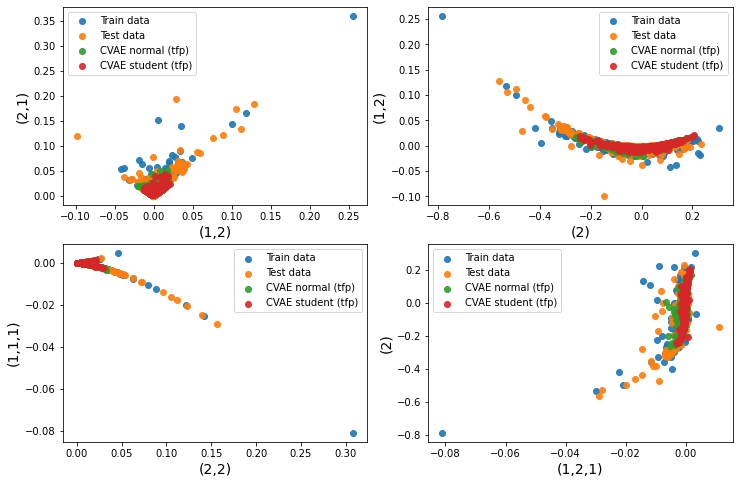

In [35]:
from esig.tosig import sigkeys

keys = sigkeys(2, order).split()

factor = []
for i in keys:
    factor.append((np.ceil((len(i)-2)/2)))
factor = np.array(factor)

PROJECTIONS = [(4, 5), (2, 4), (6, 7), (9, 2)]

# set_sig = [train_sig, test_sig, generated_sig, generated_sig1, generated_sig2]
# set_name = ["Train data", "Test data", "CVAE normal (keras)", "CVAE normal (tfp)", "CVAE student (tfp)"]

set_sig = [train_sig, test_sig, generated_sig1, generated_sig2]
set_name = ["Train data", "Test data", "CVAE normal (tfp)", "CVAE student (tfp)"]

plt.figure(figsize=(12, 8))
for i, projection in enumerate(PROJECTIONS):
    plt.subplot(2, 2, i + 1)
    for j, signame in enumerate(zip(set_sig, set_name)):
        sig, name = signame
        plt.scatter(sig[:, projection[0]], sig[:, projection[1]],label=name, alpha = 0.9)
    plt.xlabel(keys[projection[0]], fontsize=14)
    plt.ylabel(keys[projection[1]], fontsize=14)
#     plt.xticks([])
#     plt.yticks([])
    plt.legend()
    
plt.show()

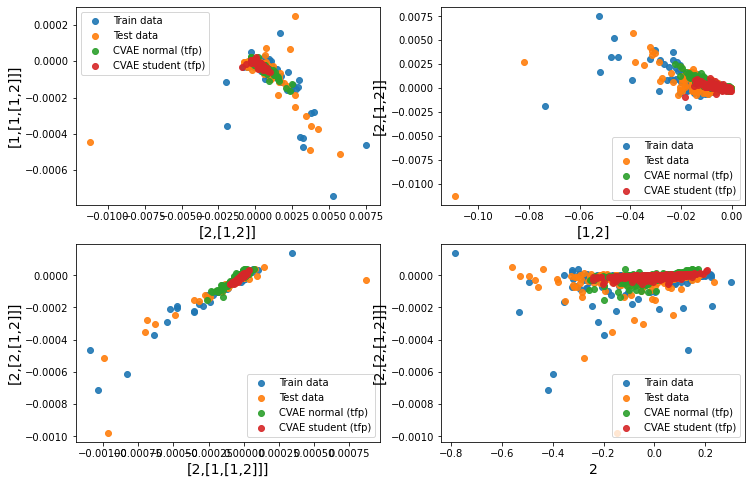

In [36]:
from esig.tosig import logsigkeys
import re

logkeys = logsigkeys(2, order).split()

logfactor = []
for i in logkeys:
    logfactor.append((len(re.sub("\D", "", i))))
logfactor = np.array(logfactor)

PROJECTIONS = [(4, 5), (2, 4), (6, 7), (1, 7)]

set_logsig = [train_logsig, test_logsig, generated_logsig1, generated_logsig2]
set_name = ["Train data", "Test data", "CVAE normal (tfp)", "CVAE student (tfp)"]

plt.figure(figsize=(12, 8))
for i, projection in enumerate(PROJECTIONS):
    plt.subplot(2, 2, i+1)
    for sig, name in zip(set_logsig, set_name):
        plt.scatter(sig[:, projection[0]], sig[:, projection[1]],label=name, alpha = 0.9)
        
    plt.xlabel(logkeys[projection[0]], fontsize=14)
    plt.ylabel(logkeys[projection[1]], fontsize=14)
#     plt.xticks([])
#     plt.yticks([])
    plt.legend()
plt.show()

## Evaluation

In [12]:
import evaluation
reload(evaluation)

import process_discriminator
reload(process_discriminator)

<module 'process_discriminator' from '../src\\process_discriminator.py'>

In [13]:
phi1 = process_discriminator.T_global(test_sig[1:], generated_sig1,\
                                     order=4, verbose=False, normalise=True, compute_sigs=False)
phi2 = process_discriminator.T_global(test_sig[1:], generated_sig2,\
                                     order=4, verbose=False, normalise=True, compute_sigs=False)
phi = min(phi1,phi2)

0.9999999999951377
0.9999999999964828


In [14]:
TU0 = []
TU1 = []
TU2 = []
for i in range(10):
    windows1 = _load_rough_bergomi(params)
    sig1 = np.array([_sig(path) for path in tqdm(windows1, desc="Computing signatures")])
    
    windows2 = _load_rough_bergomi(params)
    sig2 = np.array([_sig(path) for path in tqdm(windows2, desc="Computing signatures")])

    normalised_generated1 = model_normal.generate(data_cond)
    generated_logsig1 = scaler.inverse_transform(normalised_generated1)
    generated_sig1 = np.array([tosig.logsig2sig(logsig, 2, order) for logsig in tqdm(generated_logsig1)])

    normalised_generated2 = model_student.generate(data_cond)
    generated_logsig2 = scaler.inverse_transform(normalised_generated2)
    generated_sig2 = np.array([tosig.logsig2sig(logsig, 2, order) for logsig in tqdm(generated_logsig2)])
    
    result, TU = process_discriminator.test_fix(sig1[1:], sig2[1:],\
                                                order=order, confidence_level=0.99, phi_x = phi, compute_sigs=False)
    TU0.append(TU)
    result, TU = process_discriminator.test_fix(sig1[1:], generated_sig1,\
                                                order=order, confidence_level=0.99, phi_x = phi, compute_sigs=False)
    TU1.append(TU)
    result, TU = process_discriminator.test_fix(sig1[1:], generated_sig2,\
                                                order=order, confidence_level=0.99, phi_x = phi, compute_sigs=False)
    TU2.append(TU)


0.9999999999951377
c: 0.012687251081145167
TU: 4.311966741932238e-05
m: 999



0.9999999999951377
c: 0.012687251081145167
TU: 0.00036006606468319546
m: 999



0.9999999999951377
c: 0.012687251081145167
TU: 0.003187642465826368
m: 999



0.9999999999951377
c: 0.012687251081145167
TU: 7.580322285871688e-06
m: 999



0.9999999999951377
c: 0.012687251081145167
TU: 0.00038785782698891325
m: 999



0.9999999999951377
c: 0.012687251081145167
TU: 0.0034877650514371084
m: 999



0.9999999999951377
c: 0.012687251081145167
TU: 1.4834959827680905e-05
m: 999



0.9999999999951377
c: 0.012687251081145167
TU: 0.0004598876646619843
m: 999



0.9999999999951377
c: 0.012687251081145167
TU: 0.004480831278007358
m: 999


KeyboardInterrupt: 

In [ ]:
TU = np.array([TU0, TU1, TU2])
label = ['TU0', 'TU1', 'TU2'] 
plt.figure(figsize = (10,4))
plt.hist(TU.T, bins = 20, density=True, histtype='bar', stacked=True, label = label)
plt.legend()
plt.show()

## From Signature to Path

In [9]:
import logsig_inversion
from esig.tosig import stream2logsig
from utils.leadlag import leadlag
from gpsig import kernels
import gpflow

In [10]:
pip = 0.001
n_pips = 5 * 10
n_points = 28
n_iterations = 100
n_organisms = 100
recovered_paths = []
for i, logsig in enumerate(generated):
    recovered_paths.append(logsig_inversion.train(logsig, order, n_iterations, n_organisms, n_points, pip, n_pips)[0] + 1.)
    

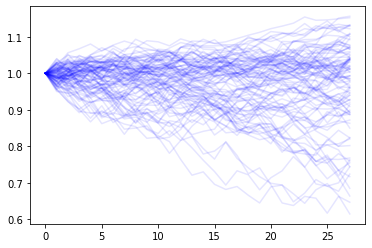

In [15]:
plt.plot(np.array(recovered_paths).T, "b", alpha=0.1)
plt.show()